In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/disaster-tweets/tweets.csv


In [2]:
import matplotlib.pyplot as plt

In [3]:
tweets = pd.read_csv('/kaggle/input/disaster-tweets/tweets.csv')
#test = pd.read_csv('/kaggle/input/nlp-getting-started/test.csv')

In [4]:
tweets.head()

,id,keyword,location,text,target
0,0,ablaze,NaN,"Communal violence in Bhainsa, Telangana. ""Ston...",1
1,1,ablaze,NaN,Telangana: Section 144 has been imposed in Bha...,1
2,2,ablaze,New York City,Arsonist sets cars ablaze at dealership https:...,1
3,3,ablaze,"Morgantown, WV",Arsonist sets cars ablaze at dealership https:...,1
4,4,ablaze,NaN,"""Lord Jesus, your love brings freedom and pard...",0


In [5]:
from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(tweets.drop(['id','keyword','location','target'],axis=1), tweets[['target']], test_size=0.2, stratify=tweets[['target']], random_state=0)
X_train_text = X_train['text']
X_val_text = X_val['text']

print('X_train shape: ', X_train.shape)
print('X_val shape: ', X_val.shape)
print('y_train shape: ', y_train.shape)
print('y_val shape: ', y_val.shape)

X_train shape:  (9096, 1)
X_val shape:  (2274, 1)
y_train shape:  (9096, 1)
y_val shape:  (2274, 1)


<AxesSubplot:>

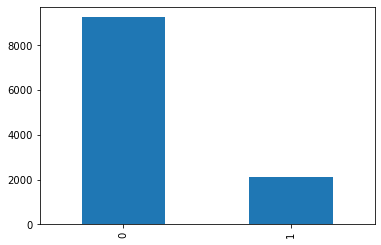

In [6]:
tweets['target'].value_counts().plot(kind='bar')

In [7]:
classes = y_val['target'].unique()

In [8]:
from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
import time
from sklearn.metrics import classification_report
from sklearn.metrics import accuracy_score


In [9]:
import spacy
import en_core_web_lg
nlp = spacy.load('en_core_web_lg', disable=["tagger", "parser", "ner"])
def preprocess(text):
    # TODO: Replace the next line with your own code.
   
    doc = nlp(text)
 
    final_key=[]
    for token in doc:
        if token.is_stop==False and token.lemma_.isalpha():
            
            final_key.append(token.lemma_)
        
    return final_key

In [10]:
from sklearn.linear_model import LogisticRegression

LR_pipeline = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=preprocess)),
    ('classifier', LogisticRegression(max_iter=400))
])

start=time.time()
# accessing and using the pipelines
LR_fit = LR_pipeline.fit(X_train_text, y_train['target'])

stop=time.time()


In [11]:
LR_pipeline.get_params()

{'memory': None,
 'steps': [('vectorizer',
   CountVectorizer(tokenizer=<function preprocess at 0x7fa56722c4d0>)),
  ('classifier', LogisticRegression(max_iter=400))],
 'verbose': False,
 'vectorizer': CountVectorizer(tokenizer=<function preprocess at 0x7fa56722c4d0>),
 'classifier': LogisticRegression(max_iter=400),
 'vectorizer__analyzer': 'word',
 'vectorizer__binary': False,
 'vectorizer__decode_error': 'strict',
 'vectorizer__dtype': numpy.int64,
 'vectorizer__encoding': 'utf-8',
 'vectorizer__input': 'content',
 'vectorizer__lowercase': True,
 'vectorizer__max_df': 1.0,
 'vectorizer__max_features': None,
 'vectorizer__min_df': 1,
 'vectorizer__ngram_range': (1, 1),
 'vectorizer__preprocessor': None,
 'vectorizer__stop_words': None,
 'vectorizer__strip_accents': None,
 'vectorizer__token_pattern': '(?u)\\b\\w\\w+\\b',
 'vectorizer__tokenizer': <function __main__.preprocess(text)>,
 'vectorizer__vocabulary': None,
 'classifier__C': 1.0,
 'classifier__class_weight': None,
 'classifi

In [12]:
LR_pred = LR_fit.predict(X_val_text)

print(f'Training time for Logistic Regression: {stop-start}sec')
print(f'Accuracy: {accuracy_score(y_val, LR_pred)}')
print(classification_report(y_val, LR_pred))

Training time for Logistic Regression: 3.6566624641418457sec
Accuracy: 0.8891820580474934
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1851
           1       0.78      0.57      0.65       423

    accuracy                           0.89      2274
   macro avg       0.84      0.76      0.79      2274
weighted avg       0.88      0.89      0.88      2274



In [15]:
from sklearn.model_selection import GridSearchCV

parameters = {
    'vectorizer__binary': (True, False),
    'vectorizer__ngram_range': ((1, 1), (1, 2)),  # unigrams or bigrams
    'classifier__C': (1, 0.1, 0.5),
    'classifier__solver' : ('newton-cg', 'lbfgs', 'liblinear')
    
}
start=time.time()
clf = GridSearchCV(LR_pipeline, parameters, cv=5)
cv_model=clf.fit(X_train_text, y_train['target'])
stop=time.time()

In [16]:
clf.best_params_

{'classifier__C': 1,
 'classifier__solver': 'newton-cg',
 'vectorizer__binary': False,
 'vectorizer__ngram_range': (1, 2)}

In [17]:

print(f'training time for Logistic regression: {stop-start}')
print(classification_report(y_val, cv_model.predict(X_val_text)))

training time for Logistic regression: 454.31541323661804
              precision    recall  f1-score   support

           0       0.91      0.98      0.94      1851
           1       0.88      0.58      0.70       423

    accuracy                           0.91      2274
   macro avg       0.90      0.78      0.82      2274
weighted avg       0.90      0.91      0.90      2274



In [18]:
##Fitting the model after preprocessing

LR_pipeline_tokenized = Pipeline([
    ('vectorizer', CountVectorizer(tokenizer=preprocess)),
    ('classifier', LogisticRegression(max_iter=400))
])

start=time.time()
# accessing and using the pipelines
LR_fit_tokenized = LR_pipeline_tokenized.fit(X_train_text, y_train['target'])

stop=time.time()


In [19]:
LR_pred_tokenized = LR_fit_tokenized.predict(X_val_text)

print(f'Training time for Logistic Regression: {stop-start}sec')
print(f'Accuracy: {accuracy_score(y_val, LR_pred_tokenized)}')
print(classification_report(y_val, LR_pred_tokenized))

Training time for Logistic Regression: 2.339287519454956sec
Accuracy: 0.8891820580474934
              precision    recall  f1-score   support

           0       0.91      0.96      0.93      1851
           1       0.78      0.57      0.65       423

    accuracy                           0.89      2274
   macro avg       0.84      0.76      0.79      2274
weighted avg       0.88      0.89      0.88      2274



In [20]:
# Hyperparameters
maxlen = 160
lr = 1e-5  
num_epochs = 3
batch_size=16 # batch size cannot be too big for bert

In [21]:
# We will use the official tokenization script created by the Google team
!wget --quiet https://raw.githubusercontent.com/tensorflow/models/master/official/nlp/bert/tokenization.py

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.layers import Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Model
from tensorflow.keras.callbacks import ModelCheckpoint
import tokenization


def bert_encode(texts, tokenizer, max_len=512):
    all_tokens = []
    all_masks = []
    all_segments = []
    
    for text in texts:
        text = tokenizer.tokenize(text)
            
        text = text[:max_len-2]
        input_sequence = ["[CLS]"] + text + ["[SEP]"]
        pad_len = max_len - len(input_sequence)
        
        tokens = tokenizer.convert_tokens_to_ids(input_sequence)
        tokens += [0] * pad_len
        pad_masks = [1] * len(input_sequence) + [0] * pad_len
        segment_ids = [0] * max_len
        
        all_tokens.append(tokens)
        all_masks.append(pad_masks)
        all_segments.append(segment_ids)
    
    return np.array(all_tokens), np.array(all_masks), np.array(all_segments)

In [22]:

   def build_model(bert_layer, max_len=512, lr=1e-5):
    input_word_ids = Input(shape=(max_len,), dtype=tf.int32, name="input_word_ids")
    input_mask = Input(shape=(max_len,), dtype=tf.int32, name="input_mask")
    segment_ids = Input(shape=(max_len,), dtype=tf.int32, name="segment_ids")

    _, sequence_output = bert_layer([input_word_ids, input_mask, segment_ids])
    clf_output = sequence_output[:, 0, :]
    out = Dense(1, activation='sigmoid')(clf_output)
    
    model = Model(inputs=[input_word_ids, input_mask, segment_ids], outputs=out)
    model.compile(Adam(lr=lr), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

In [23]:

module_url = "https://tfhub.dev/tensorflow/bert_en_uncased_L-24_H-1024_A-16/1"
bert_layer = hub.KerasLayer(module_url, trainable=True)

vocab_file = bert_layer.resolved_object.vocab_file.asset_path.numpy()
do_lower_case = bert_layer.resolved_object.do_lower_case.numpy()
tokenizer = tokenization.FullTokenizer(vocab_file, do_lower_case)

In [24]:
train_input = bert_encode(X_train.text.values, tokenizer, max_len=maxlen)
val_input = bert_encode(X_val.text.values, tokenizer, max_len=maxlen)
train_labels = y_train.target.values
val_labels = y_val.target.values

In [25]:
bert_model = build_model(bert_layer, max_len=maxlen, lr=lr)
bert_model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]             

In [26]:
checkpoint = ModelCheckpoint('bertmodel.h5', monitor='val_accuracy', save_best_only=True)

start=time.time()
bert_history = bert_model.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=num_epochs,
    callbacks=[checkpoint], 
    batch_size=batch_size
)

stop=time.time()

Epoch 1/3
455/455 [==============================] - 445s 978ms/step - loss: 0.1410 - accuracy: 0.9469 - val_loss: 0.2409 - val_accuracy: 0.9181
Epoch 3/3
455/455 [==============================] - 445s 978ms/step - loss: 0.0380 - accuracy: 0.9881 - val_loss: 0.2893 - val_accuracy: 0.9225


In [27]:
y_bert = bert_model.predict(val_input)

In [28]:
print(f'Training time for BERT: {stop-start}')
print(f'Accuracy: {accuracy_score(y_val, y_bert.round().astype(int))}')
print(classification_report(y_val, y_bert.round().astype(int)))

Training time for BERT: 1467.9569585323334
Accuracy: 0.920844327176781
              precision    recall  f1-score   support

           0       0.93      0.97      0.95      1851
           1       0.85      0.70      0.77       423

    accuracy                           0.92      2274
   macro avg       0.89      0.84      0.86      2274
weighted avg       0.92      0.92      0.92      2274



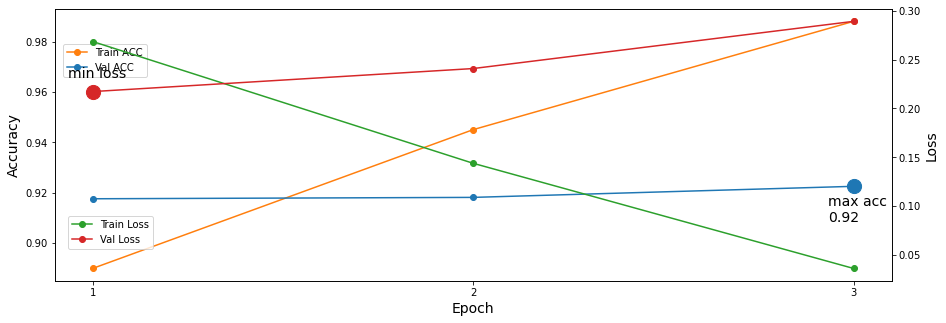

In [29]:
plt.figure(figsize=(15,5))
plt.plot(range(num_epochs), bert_history.history['accuracy'],'-o',label='Train ACC',color='#ff7f0e')
plt.plot(range(num_epochs),bert_history.history['val_accuracy'],'-o',label='Val ACC',color='#1f77b4')
x = np.argmax( bert_history.history['val_accuracy'] ); y = np.max( bert_history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#1f77b4')
plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
plt.ylabel('Accuracy',size=14); plt.xlabel('Epoch',size=14)
plt.legend(loc=(0.01,0.75))

plt2 = plt.gca().twinx()
plt2.plot(range(num_epochs),bert_history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(range(num_epochs),bert_history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( bert_history.history['val_loss'] ); y = np.min( bert_history.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728')
plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
   # plt.ylim([-0.2, 2])
plt.ylabel('Loss',size=14)
plt.xticks(ticks=list(range(num_epochs)),labels=list(range(1, num_epochs+1)))
plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1))
plt.show()


In [30]:
## Create balanced dataset

from imblearn.under_sampling import RandomUnderSampler

undersample = RandomUnderSampler(sampling_strategy='auto')
X_resampled, y_resampled = undersample.fit_resample(X_train[['text']], y_train['target'])


X_resampled=pd.DataFrame(data=X_resampled, columns=['text'])
y_resampled=y_resampled.tolist()
y_resampled=pd.DataFrame(data=y_resampled, columns=['target'])

<AxesSubplot:>

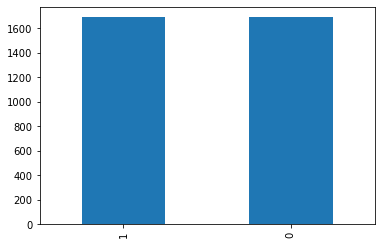

In [31]:
y_resampled['target'].value_counts().plot(kind='bar')

In [32]:
LR_refit = LR_pipeline.fit(X_resampled['text'], y_resampled['target'])

LR_repred = LR_fit.predict(X_val_text)

print(f'Training time for Logistic Regression: {stop-start}sec')
print(f'Accuracy: {accuracy_score(y_val, LR_repred)}')
print(classification_report(y_val, LR_repred))

Training time for Logistic Regression: 1467.9569585323334sec
Accuracy: 0.8276165347405453
              precision    recall  f1-score   support

           0       0.95      0.83      0.89      1851
           1       0.52      0.81      0.64       423

    accuracy                           0.83      2274
   macro avg       0.74      0.82      0.76      2274
weighted avg       0.87      0.83      0.84      2274



In [33]:
start=time.time()
clf_re = GridSearchCV(LR_pipeline, parameters, cv=5)
cv_remodel=clf_re.fit(X_resampled['text'], y_resampled['target'])
stop=time.time()

clf_re.best_params_

{'classifier__C': 1,
 'classifier__solver': 'liblinear',
 'vectorizer__binary': False,
 'vectorizer__ngram_range': (1, 2)}

In [34]:
print(f'training time: {stop-start}')
print(classification_report(y_val, cv_remodel.predict(X_val_text)))

training time: 171.23980593681335
              precision    recall  f1-score   support

           0       0.95      0.86      0.90      1851
           1       0.56      0.79      0.66       423

    accuracy                           0.85      2274
   macro avg       0.76      0.83      0.78      2274
weighted avg       0.88      0.85      0.86      2274



In [35]:
train_input = bert_encode(X_resampled.text.values, tokenizer, max_len=maxlen)
val_input = bert_encode(X_val.text.values, tokenizer, max_len=maxlen)
train_labels = y_resampled.target.values
val_labels = y_val.target.values

In [36]:
bert_model2 = build_model(bert_layer, max_len=maxlen, lr=lr)
bert_model2.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_word_ids (InputLayer)     [(None, 160)]        0                                            
__________________________________________________________________________________________________
input_mask (InputLayer)         [(None, 160)]        0                                            
__________________________________________________________________________________________________
segment_ids (InputLayer)        [(None, 160)]        0                                            
__________________________________________________________________________________________________
keras_layer (KerasLayer)        [(None, 1024), (None 335141889   input_word_ids[0][0]             
                                                                 input_mask[0][0]           

In [37]:
checkpoint = ModelCheckpoint('bertmodel.h5', monitor='val_accuracy', save_best_only=True)

start=time.time()
bert_history = bert_model2.fit(
    train_input, train_labels,
    validation_split=0.2,
    epochs=num_epochs,
    callbacks=[checkpoint], 
    batch_size=batch_size
)
stop=time.time()

Epoch 1/3
170/170 [==============================] - 186s 993ms/step - loss: 0.1518 - accuracy: 0.9378 - val_loss: 0.4607 - val_accuracy: 0.8833
Epoch 2/3
170/170 [==============================] - 166s 974ms/step - loss: 0.0117 - accuracy: 0.9972 - val_loss: 1.0697 - val_accuracy: 0.7637
Epoch 3/3
170/170 [==============================] - 166s 974ms/step - loss: 0.0267 - accuracy: 0.9938 - val_loss: 0.4605 - val_accuracy: 0.9025


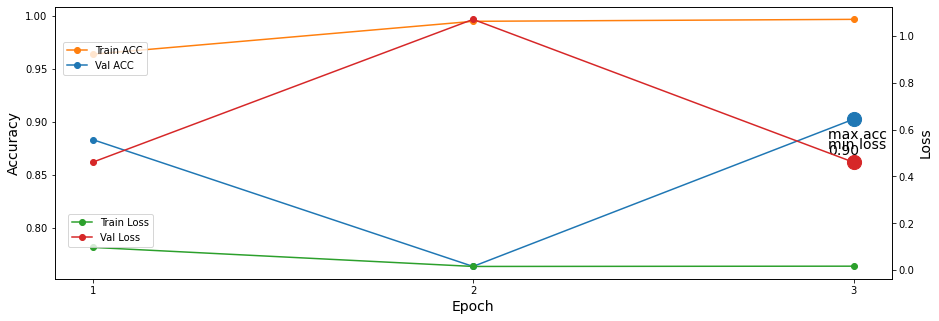

In [38]:
plt.figure(figsize=(15,5))
plt.plot(range(num_epochs), bert_history.history['accuracy'],'-o',label='Train ACC',color='#ff7f0e')
plt.plot(range(num_epochs),bert_history.history['val_accuracy'],'-o',label='Val ACC',color='#1f77b4')
x = np.argmax( bert_history.history['val_accuracy'] ); y = np.max( bert_history.history['val_accuracy'] )
xdist = plt.xlim()[1] - plt.xlim()[0]; ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#1f77b4')
plt.text(x-0.03*xdist,y-0.13*ydist,'max acc\n%.2f'%y,size=14)
plt.ylabel('Accuracy',size=14); plt.xlabel('Epoch',size=14)
plt.legend(loc=(0.01,0.75))

plt2 = plt.gca().twinx()
plt2.plot(range(num_epochs),bert_history.history['loss'],'-o',label='Train Loss',color='#2ca02c')
plt2.plot(range(num_epochs),bert_history.history['val_loss'],'-o',label='Val Loss',color='#d62728')
x = np.argmin( bert_history.history['val_loss'] ); y = np.min( bert_history.history['val_loss'] )
ydist = plt.ylim()[1] - plt.ylim()[0]
plt.scatter(x,y,s=200,color='#d62728')
plt.text(x-0.03*xdist,y+0.05*ydist,'min loss',size=14)
   # plt.ylim([-0.2, 2])
plt.ylabel('Loss',size=14)
plt.xticks(ticks=list(range(num_epochs)),labels=list(range(1, num_epochs+1)))
plt.legend(loc='lower left', bbox_to_anchor=(0.01, 0.1))
plt.show()

In [39]:
y_bert2 = bert_model2.predict(val_input)

In [40]:
print(f'Training Time: {stop-start}')
print(f'Accuracy: {accuracy_score(y_val, y_bert2.round().astype(int))}')
print(classification_report(y_val, y_bert2.round().astype(int)))

Training Time: 584.7240743637085
Accuracy: 0.9151275285839929
              precision    recall  f1-score   support

           0       0.96      0.94      0.95      1851
           1       0.75      0.82      0.78       423

    accuracy                           0.92      2274
   macro avg       0.85      0.88      0.87      2274
weighted avg       0.92      0.92      0.92      2274

